# Comparaison model métier (Signal_Model_Compar) vs model baseline (Signal_Baseline_Model_v2)

## 1 - IMPORTS + CHARGEMENT DES DF

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set path to datasets
DATA_DIR = Path('../src/ose_core/data_ingestion/extracted_datasets')

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load signals data
df_signals = pd.read_csv(DATA_DIR / '08_signals.csv', dtype={'siren': str, 'siret': str})

print(f"Dataset shape: {df_signals.shape}")
print(f"\nColumns: {list(df_signals.columns)}")
display(df_signals.head(3))

Dataset shape: (2133, 12)

Columns: ['company_name', 'siren', 'siret', 'continent', 'country', 'departement', 'publishedAt', 'isMain', 'type', 'createdAt', 'companies_count', 'sirets_count']


,company_name,siren,siret,continent,country,departement,publishedAt,isMain,type,createdAt,companies_count,sirets_count
0,PAIN D'EPICES MULOT ET PETITJEAN,015751530,01575153000013,"[{'id': 6, 'label': 'Europe'}]","[{'id': 72, 'label': 'France'}]","[{'parent': 'Bourgogne-Franche-Comté', 'id': 2...",2021-09-30T00:00:00+02:00,True,"{'code': 'K1', 'id': 32, 'label': 'Investissem...",2020-09-07T15:14:38+02:00,1,1
1,PAIN D'EPICES MULOT ET PETITJEAN,015751530,01575153000013,"[{'id': 6, 'label': 'Europe'}]","[{'id': 72, 'label': 'France'}]","[{'parent': 'Bourgogne-Franche-Comté', 'id': 2...",2020-09-08T00:00:00+02:00,True,"{'code': 'L', 'id': 12, 'label': 'Levée de fon...",2020-09-07T15:14:12+02:00,1,1
2,PAIN D'EPICES MULOT ET PETITJEAN,015751530,01575153000013,NaN,NaN,NaN,2016-09-21T00:00:00+02:00,True,"{'code': 'F', 'id': 6, 'label': ""Développement...",2016-09-20T10:45:13+02:00,1,1


In [4]:
# Summary
print(f"\nSignals Summary:")
print(f"Total signal records: {len(df_signals)}")
print(f"Unique companies with signals: {df_signals['siren'].nunique()}")
print(f"Average signals per company: {len(df_signals) / df_signals['siren'].nunique():.1f}")
print(f"\nSignal types:")
if 'type' in df_signals.columns:
    print(df_signals['type'].value_counts().head(10))
print(f"\nCountries:")
if 'country' in df_signals.columns:
    print(df_signals['country'].value_counts().head(10))


Signals Summary:
Total signal records: 2133
Unique companies with signals: 266
Average signals per company: 8.0

Signal types:
type
{'code': 'B', 'id': 2, 'label': 'Construction'}                                       309
{'code': 'K1', 'id': 32, 'label': 'Investissements'}                                  282
{'code': 'N', 'id': 14, 'label': 'Recrutement'}                                       214
{'code': 'L', 'id': 12, 'label': 'Levée de fonds, financements & modifs. capital'}    205
{'code': 'F', 'id': 6, 'label': "Développement de l'activité"}                        193
{'code': 'Hbis', 'id': 24, 'label': 'Activité internationale (industrie)'}            129
{'code': 'P', 'id': 16, 'label': 'Vente & Cession'}                                   105
{'code': 'S', 'id': 19, 'label': 'Lancement'}                                          87
{'code': 'E', 'id': 5, 'label': 'Créations & ouvertures'}                              63
{'code': 'U', 'id': 21, 'label': 'Nomination'}           

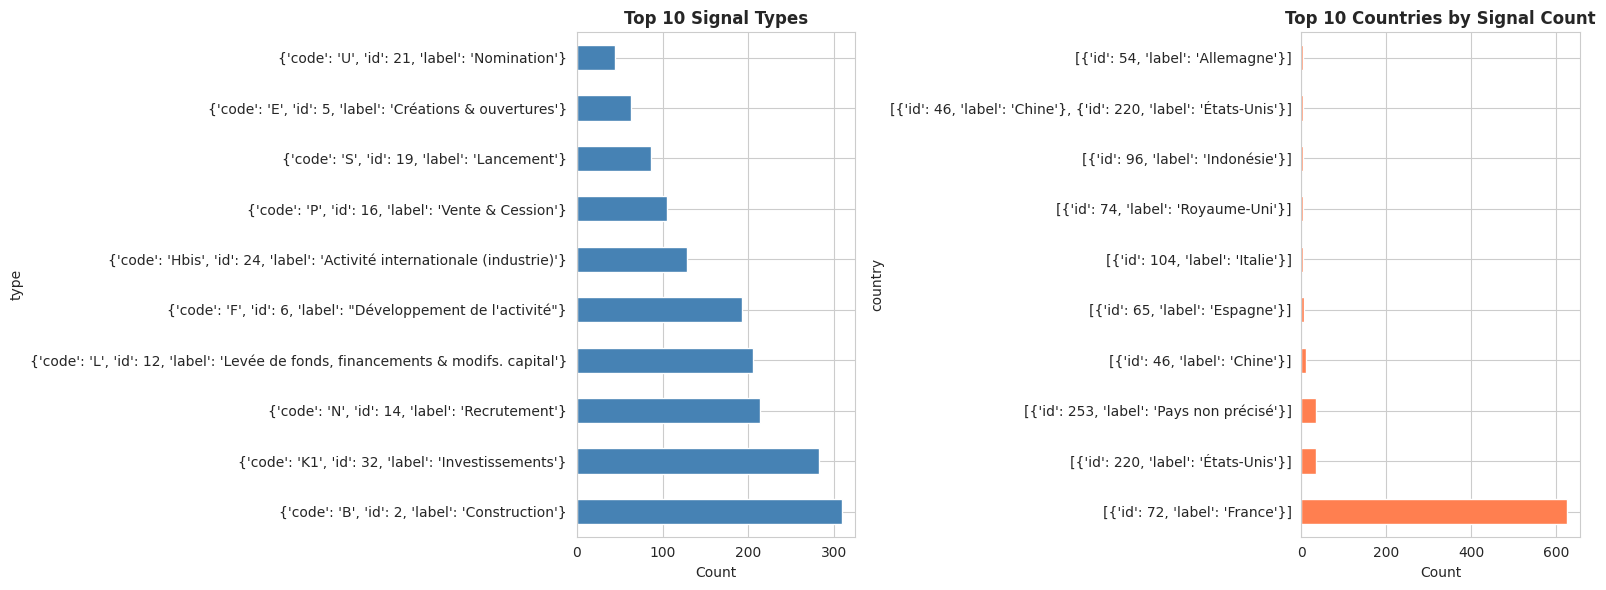

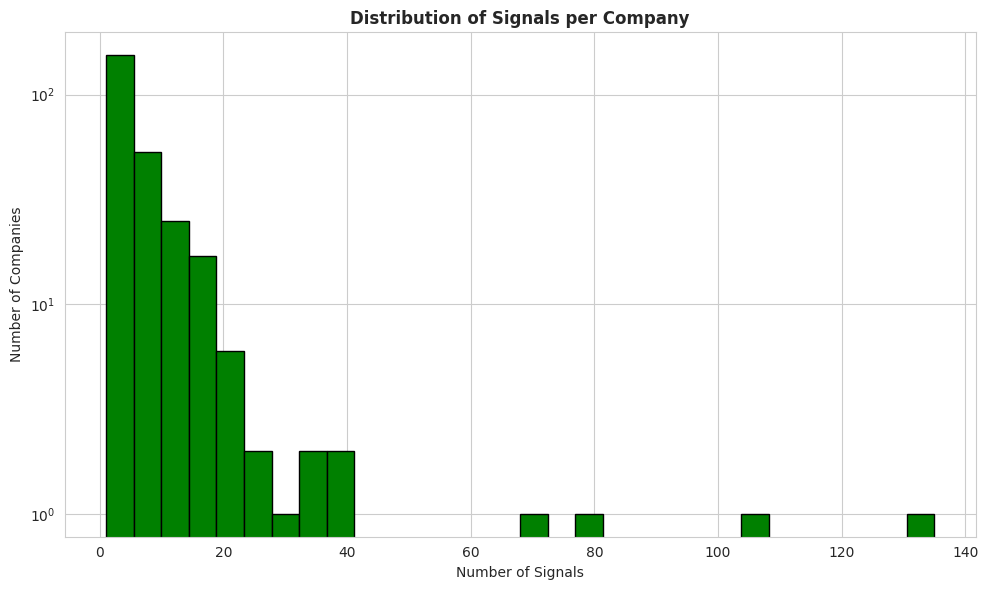

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Signal types
if 'type' in df_signals.columns:
    signal_types = df_signals['type'].value_counts().head(10)
    signal_types.plot(kind='barh', ax=axes[0], color='steelblue')
    axes[0].set_title('Top 10 Signal Types', fontweight='bold')
    axes[0].set_xlabel('Count')

# Countries
if 'country' in df_signals.columns:
    countries = df_signals['country'].value_counts().head(10)
    countries.plot(kind='barh', ax=axes[1], color='coral')
    axes[1].set_title('Top 10 Countries by Signal Count', fontweight='bold')
    axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

# Signals per company distribution
signals_per_company = df_signals.groupby('siren').size()
plt.figure(figsize=(10, 6))
signals_per_company.hist(bins=30, color='green', edgecolor='black')
plt.title('Distribution of Signals per Company', fontweight='bold')
plt.xlabel('Number of Signals')
plt.ylabel('Number of Companies')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [6]:
df_sig = df_signals.copy()

In [7]:
#nettoyage
#transfo date
def to_datetime_robust(series):
    """
    Convertit une série en datetime en gérant :
    - timestamps numériques (en secondes)
    - strings '2024-01-01T...' ou similaires
    """
    if np.issubdtype(series.dtype, np.number):
        return pd.to_datetime(series, unit="s", errors="coerce")
    else:
        return pd.to_datetime(series, errors="coerce")

In [8]:
# SIREN en string
df_sig["siren"] = df_sig["siren"].astype(str)


df_sig["publishedAt_dt"] = to_datetime_robust(df_sig["publishedAt"])
df_sig["createdAt_dt"]   = to_datetime_robust(df_sig["createdAt"])

# Date du signal : priorité publishedAt, sinon createdAt
df_sig["sig_date"] = df_sig["publishedAt_dt"].fillna(df_sig["createdAt_dt"])

# (optionnel mais propre) : enlever les lignes sans date exploitable
df_sig = df_sig[~df_sig["sig_date"].isna()].copy()

# Petit check
display(df_sig['type'].value_counts().head(10))
display(df_sig[["siren", "type", "sig_date"]].head())

/tmp/ipykernel_149704/1670592371.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(series, errors="coerce")
/tmp/ipykernel_149704/1670592371.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(series, errors="coerce")


type
{'code': 'B', 'id': 2, 'label': 'Construction'}                                       309
{'code': 'K1', 'id': 32, 'label': 'Investissements'}                                  282
{'code': 'N', 'id': 14, 'label': 'Recrutement'}                                       214
{'code': 'L', 'id': 12, 'label': 'Levée de fonds, financements & modifs. capital'}    205
{'code': 'F', 'id': 6, 'label': "Développement de l'activité"}                        193
{'code': 'Hbis', 'id': 24, 'label': 'Activité internationale (industrie)'}            129
{'code': 'P', 'id': 16, 'label': 'Vente & Cession'}                                   105
{'code': 'S', 'id': 19, 'label': 'Lancement'}                                          87
{'code': 'E', 'id': 5, 'label': 'Créations & ouvertures'}                              63
{'code': 'U', 'id': 21, 'label': 'Nomination'}                                         45
Name: count, dtype: int64

,siren,type,sig_date
0,015751530,"{'code': 'K1', 'id': 32, 'label': 'Investissem...",2021-09-30 00:00:00+02:00
1,015751530,"{'code': 'L', 'id': 12, 'label': 'Levée de fon...",2020-09-08 00:00:00+02:00
2,015751530,"{'code': 'F', 'id': 6, 'label': ""Développement...",2016-09-21 00:00:00+02:00
3,015751530,"{'code': 'F', 'id': 6, 'label': ""Développement...",2018-04-06 00:00:00+02:00
4,015751530,"{'code': 'E', 'id': 5, 'label': 'Créations & o...",2018-04-06 00:00:00+02:00


In [9]:
def normalize_type(type_str):
    """
    À partir d'une chaîne du type "{'code': 'L', 'label_short': ..., 'id': 12, 'label': ...}",
    retourne un identifiant unique basé uniquement sur code + id + label.
    """
    try:
        d = ast.literal_eval(type_str)  # convertir la string en dict
        code = d.get("code")
        type_id = d.get("id")
        label = d.get("label")
        return f"{code}_{type_id}_{label}"
    except:
        return None

df_sig["type_normalized"] = df_sig["type"].apply(normalize_type)

In [10]:
df_pivot = (
    df_sig
      .groupby(["siren", "type_normalized"])
      .size()
      .reset_index(name="count")
      .pivot(index="siren", columns="type_normalized", values="count")
      .fillna(0)
)

df_pivot.head(5)

type_normalized,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,H_8_Activité internationale (tertiaire),...,R_18_Décroissance,S_19_Lancement,U_21_Nomination,W_23_Foncier & bâti,X_25_Actualité entreprise,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda
siren,,,,,,,,,,,,,,,,,,,,,
015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### model baseline

In [11]:
# diversité des signaux
df_pivot["diversite_signaux"] = (df_pivot > 0).sum(axis=1)
#print(df_pivot["diversite_signaux"].head)

In [12]:
df_recency = (
    df_sig
      .groupby("siren")["sig_date"]
      .max()
      .reset_index()
      .rename(columns={"sig_date": "last_signal_date"})
)
df_recency.head(5)

,siren,last_signal_date
0,015751530,2025-03-03 00:15:21+01:00
1,046580031,2022-08-08 00:00:00+02:00
2,057504649,2024-06-16 00:00:00+02:00
3,086781150,2023-06-29 00:00:00+02:00
4,096780838,2024-03-11 00:00:00+01:00


In [13]:
# date signal la plus récente
reference_date = df_recency["last_signal_date"].max()
reference_date

Timestamp('2025-11-19 00:15:35+0100', tz='UTC+01:00')

In [14]:
df_recency["last_signal_date"] = pd.to_datetime(
    df_recency["last_signal_date"],
    errors="coerce"
)

# Delta en jours
df_recency["recency_jours"] = (reference_date - df_recency["last_signal_date"]).dt.days

df_recency["recency_jours"].head(5)

0    261.0
1      NaN
2      NaN
3      NaN
4    618.0
Name: recency_jours, dtype: float64

In [15]:
# merge signaux et recency par siren pour le model
df_model = df_pivot.merge(df_recency[["siren", "recency_jours"]], on="siren", how="left")
# dégager les NaN dans recency
df_model["recency_jours"] = df_model["recency_jours"].fillna(df_model["recency_jours"].max())
df_model.head()

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,U_21_Nomination,W_23_Foncier & bâti,X_25_Actualité entreprise,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda,diversite_signaux,recency_jours
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11,261.0
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4017.0
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4017.0
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4017.0
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5,618.0


In [16]:
# S'assurer que sig_date est bien au format datetime
df_sig["sig_date"] = pd.to_datetime(df_sig["sig_date"], errors="coerce")

# Optionnel : virer les lignes qui n'ont toujours pas de date exploitable
df_sig = df_sig[~df_sig["sig_date"].isna()].copy()

# nouvelle info mois
df_sig["month"] = df_sig["sig_date"].dt.to_period("M")
last_month = df_sig["month"].max()
three_months_ago = last_month - 2  # last month, -1, -2 = 3 mois
twelve_months_ago = last_month - 11
two_years_ago = last_month - 23
tree_years_ago = last_month - 35
four_years_ago = last_month - 47
five_years_ago = last_month - 59
six_years_ago = last_month - 71
seven_years_ago = last_month - 83
eight_years_ago = last_month - 95
nine_years_ago = last_month - 107
ten_years_ago = last_month - 119
print(f"Last month : {last_month}, 3 months ago: {three_months_ago}, 1 year ago: {twelve_months_ago}, 2 years ago: {two_years_ago}, 3 years ago: {tree_years_ago}, 4 years ago: {four_years_ago}, 5 years ago: {five_years_ago}, 6 years ago: {six_years_ago}, 7 years ago: {seven_years_ago}, 8 years ago: {eight_years_ago}, 9 years ago: {nine_years_ago}, 10 years ago: {ten_years_ago}")

Last month : 2025-10, 3 months ago: 2025-08, 1 year ago: 2024-11, 2 years ago: 2023-11, 3 years ago: 2022-11, 4 years ago: 2021-11, 5 years ago: 2020-11, 6 years ago: 2019-11, 7 years ago: 2018-11, 8 years ago: 2017-11, 9 years ago: 2016-11, 10 years ago: 2015-11


/tmp/ipykernel_149704/4243298923.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_sig["month"] = df_sig["sig_date"].dt.to_period("M")


In [17]:
# signaux 1 mois
df_1m = df_sig[df_sig["month"] == last_month]
df_1m = df_1m.groupby("siren").size().reset_index(name="nb_signaux_1m")
# signaux 3 mois
df_3m = df_sig[(df_sig["month"] >= three_months_ago) & (df_sig["month"] <= last_month)]
df_3m = df_3m.groupby("siren").size().reset_index(name="nb_signaux_3m")
# signaux 12 mois
df_12m = df_sig[(df_sig["month"] >= twelve_months_ago) & (df_sig["month"] <= three_months_ago)]
df_12m = df_12m.groupby("siren").size().reset_index(name="nb_signaux_12m")
# signaux 24 mois
df_24m = df_sig[(df_sig["month"] >= two_years_ago) & (df_sig["month"] <= twelve_months_ago)]
df_24m = df_24m.groupby("siren").size().reset_index(name="nb_signaux_2y")
# signaux 36 mois
df_36m = df_sig[(df_sig["month"] >= tree_years_ago) & (df_sig["month"] <= two_years_ago)]
df_36m = df_36m.groupby("siren").size().reset_index(name="nb_signaux_3y")
# signaux 4 ans
df_4y = df_sig[(df_sig["month"] >= four_years_ago) & (df_sig["month"] <= tree_years_ago)]
df_4y = df_4y.groupby("siren").size().reset_index(name="nb_signaux_4y")
# signaux 5 ans
df_5y = df_sig[(df_sig["month"] >= five_years_ago) & (df_sig["month"] <= four_years_ago)]
df_5y = df_5y.groupby("siren").size().reset_index(name="nb_signaux_5y")
# signaux 6 ans
df_6y = df_sig[(df_sig["month"] >= six_years_ago) & (df_sig["month"] <= five_years_ago)]
df_6y = df_6y.groupby("siren").size().reset_index(name="nb_signaux_6y")
# signaux 7 ans
df_7y = df_sig[(df_sig["month"] >= seven_years_ago) & (df_sig["month"] <= six_years_ago)]
df_7y = df_7y.groupby("siren").size().reset_index(name="nb_signaux_7y")
# signaux 8 ans
df_8y = df_sig[(df_sig["month"] >= eight_years_ago) & (df_sig["month"] <= seven_years_ago)]
df_8y = df_8y.groupby("siren").size().reset_index(name="nb_signaux_8y")
# signaux 9 ans
df_9y = df_sig[(df_sig["month"] >= nine_years_ago) & (df_sig["month"] <= eight_years_ago)]
df_9y = df_9y.groupby("siren").size().reset_index(name="nb_signaux_9y")
# signaux 10 ans
df_10y = df_sig[(df_sig["month"] >= ten_years_ago) & (df_sig["month"] <= nine_years_ago)]
df_10y = df_10y.groupby("siren").size().reset_index(name="nb_signaux_10y")
#df_sig.head()
#df_1m.head()

In [18]:
#df_1m exclus
df_model_update = (
    df_model
      .merge(df_3m, on="siren", how="left")
      .merge(df_12m, on="siren", how="left")
      .merge(df_24m, on="siren", how="left")
      .merge(df_36m, on="siren", how="left")
      .merge(df_4y, on="siren", how="left")
      .merge(df_5y, on="siren", how="left")
      .merge(df_6y, on="siren", how="left")
      .merge(df_7y, on="siren", how="left")
      .merge(df_8y, on="siren", how="left")
      .merge(df_9y, on="siren", how="left")
      .merge(df_10y, on="siren", how="left")

)

for col in ["nb_signaux_3m", "nb_signaux_12m", "nb_signaux_2y", "nb_signaux_3y", "nb_signaux_4y", "nb_signaux_5y", "nb_signaux_6y", "nb_signaux_7y", "nb_signaux_8y", "nb_signaux_9y", "nb_signaux_10y"]:
    df_model_update[col] = df_model_update[col].fillna(0)

df_model_update.head(5)

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,nb_signaux_12m,nb_signaux_2y,nb_signaux_3y,nb_signaux_4y,nb_signaux_5y,nb_signaux_6y,nb_signaux_7y,nb_signaux_8y,nb_signaux_9y,nb_signaux_10y
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,7.0
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#suppression nb_signaux_total et nb_signaux_1m
#label générique : plus l'entreprise à de signaux plus elle est active, juste pour faire tourner le model avec un y
df_model_update["y_gen"] = (
    df_model_update["nb_signaux_10y"] +
    df_model_update["nb_signaux_9y"] +
    df_model_update["nb_signaux_8y"] +
    df_model_update["nb_signaux_7y"] +
    df_model_update["nb_signaux_6y"] +
    df_model_update["nb_signaux_5y"] +
    df_model_update["nb_signaux_4y"] +
    df_model_update["nb_signaux_3y"] +
    df_model_update["nb_signaux_2y"] +
    df_model_update["nb_signaux_12m"] +
    df_model_update["nb_signaux_3m"] +
    df_model_update["diversite_signaux"]
)
df_model_update["y_gen"].head(5)

0    23.0
1     8.0
2     3.0
3     3.0
4     5.0
Name: y_gen, dtype: float64

In [20]:
# normalisation pour meilleure lecture
df_model_update["y_gen_norm"] = (df_model_update["y_gen"] - df_model_update["y_gen"].mean()) / df_model_update["y_gen"].std()
df_model_update.head(5)

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,nb_signaux_3y,nb_signaux_4y,nb_signaux_5y,nb_signaux_6y,nb_signaux_7y,nb_signaux_8y,nb_signaux_9y,nb_signaux_10y,y_gen,y_gen_norm
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,1.0,1.0,0.0,3.0,0.0,7.0,23.0,1.569595
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,-0.047416
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.586420
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.586420
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-0.370818


In [21]:
df_pivot.columns

Index(['A_1_Aménagement & urbanisme', 'B_2_Construction', 'D_4_Litige',
       'D_4_Litiges', 'E_5_Création & ouverture', 'E_5_Créations & ouvertures',
       'F_6_Croissance', 'F_6_Développement de l'activité', 'G_7_Déménagement',
       'H_8_Activité internationale (tertiaire)',
       'Hbis_24_Activité internationale (industrie)', 'I_9_Fermeture',
       'I_9_Fermetures', 'K1_32_Investissements',
       'L_12_Levée de fonds, financements & modifs. capital',
       'M_13_Licenciement & chômage', 'N_14_Recrutement', 'O_15_RJ & LJ',
       'P_16_Vente & Cession', 'R_18_Décroissance', 'S_19_Lancement',
       'U_21_Nomination', 'W_23_Foncier & bâti', 'X_25_Actualité entreprise',
       'Y_26_Veille sectorielle', 'Z1_29_Engagement vert',
       'Z2_30_Restructuration, Réorganisation', 'Z3_33_Politique RH & RSE',
       'Z_27_Salon & agenda', 'diversite_signaux'],
      dtype='object', name='type_normalized')

In [22]:
# prendre toutes les colonnes de pivot signaux sans les sous-labels et les features créées
features_list_1 = [
    col for col in df_pivot.columns
    if col not in ["diversite_signaux"]
]

# liste des nouveaux indicateurs sans nb total et signaux 1m
features_list_2 = ["diversite_signaux",
    "recency_jours",
    "nb_signaux_3m",
    "nb_signaux_12m",
    "nb_signaux_2y",
    "nb_signaux_3y",
    "nb_signaux_4y",
    "nb_signaux_5y",
    "nb_signaux_6y",
    "nb_signaux_7y",
    "nb_signaux_8y",
    "nb_signaux_9y",
    "nb_signaux_10y"
]

features = features_list_1 + features_list_2
display(features)

['A_1_Aménagement & urbanisme',
 'B_2_Construction',
 'D_4_Litige',
 'D_4_Litiges',
 'E_5_Création & ouverture',
 'E_5_Créations & ouvertures',
 'F_6_Croissance',
 "F_6_Développement de l'activité",
 'G_7_Déménagement',
 'H_8_Activité internationale (tertiaire)',
 'Hbis_24_Activité internationale (industrie)',
 'I_9_Fermeture',
 'I_9_Fermetures',
 'K1_32_Investissements',
 'L_12_Levée de fonds, financements & modifs. capital',
 'M_13_Licenciement & chômage',
 'N_14_Recrutement',
 'O_15_RJ & LJ',
 'P_16_Vente & Cession',
 'R_18_Décroissance',
 'S_19_Lancement',
 'U_21_Nomination',
 'W_23_Foncier & bâti',
 'X_25_Actualité entreprise',
 'Y_26_Veille sectorielle',
 'Z1_29_Engagement vert',
 'Z2_30_Restructuration, Réorganisation',
 'Z3_33_Politique RH & RSE',
 'Z_27_Salon & agenda',
 'diversite_signaux',
 'recency_jours',
 'nb_signaux_3m',
 'nb_signaux_12m',
 'nb_signaux_2y',
 'nb_signaux_3y',
 'nb_signaux_4y',
 'nb_signaux_5y',
 'nb_signaux_6y',
 'nb_signaux_7y',
 'nb_signaux_8y',
 'nb_si

In [23]:
# pour le split
X = df_model_update[features]
y = df_model_update["y_gen_norm"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [24]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [25]:
from xgboost import XGBRegressor

model_tree = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

pipe_xgb = Pipeline([
    ("preprocess", numeric_pipe),
    ("model", model_tree)
])

pipe_xgb.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [26]:
pred_test = pipe_xgb.predict(X_test)

print("R² =", r2_score(y_test, pred_test))
print("MAE =", mean_absolute_error(y_test, pred_test))

R² = 0.9106892881247269
MAE = 0.11641158153011039


In [27]:
df_model_update["signal_score_model"] = pipe_xgb.predict(X)

In [28]:
signal_features = df_model_update[[
    "siren",
    "signal_score_model",
    "nb_signaux_10y",
    "nb_signaux_9y",
    "nb_signaux_8y",
    "nb_signaux_7y",
    "nb_signaux_6y",
    "nb_signaux_5y",
    "nb_signaux_4y",
    "nb_signaux_3y",
    "nb_signaux_2y",
    "nb_signaux_12m",
    "nb_signaux_3m",
    "diversite_signaux",
    "recency_jours"
]]

In [29]:
display(signal_features)

,siren,signal_score_model,nb_signaux_10y,nb_signaux_9y,nb_signaux_8y,nb_signaux_7y,nb_signaux_6y,nb_signaux_5y,nb_signaux_4y,nb_signaux_3y,nb_signaux_2y,nb_signaux_12m,nb_signaux_3m,diversite_signaux,recency_jours
0,015751530,1.570813,7.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,11,261.0
1,046580031,-0.047167,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4,4017.0
2,057504649,-0.526520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,4017.0
3,086781150,-0.610758,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,4017.0
4,096780838,-0.377117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,901761114,-0.683537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,309.0
262,916420128,0.696671,2.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4017.0
263,927050013,-0.485291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1,4017.0
264,947351656,0.702841,0.0,2.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6,4017.0


In [30]:
# voir la liste des goldens de Laetitia
siren_list_golden = ["509935151", "636220220","538866740","518802459","375980075","444323893","419239181"]
signal_features[signal_features["siren"].isin(siren_list_golden)]

,siren,signal_score_model,nb_signaux_10y,nb_signaux_9y,nb_signaux_8y,nb_signaux_7y,nb_signaux_6y,nb_signaux_5y,nb_signaux_4y,nb_signaux_3y,nb_signaux_2y,nb_signaux_12m,nb_signaux_3m,diversite_signaux,recency_jours
97,375980075,0.510648,0.0,2.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,7,615.0
150,419239181,-0.167102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,3,4017.0
173,444323893,0.054142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,6,243.0
204,509935151,7.699404,12.0,16.0,6.0,1.0,3.0,12.0,3.0,6.0,2.0,1.0,2.0,16,4017.0
208,518802459,2.863444,2.0,5.0,6.0,0.0,0.0,6.0,0.0,1.0,2.0,0.0,1.0,12,1.0
219,538866740,4.588228,0.0,2.0,1.0,4.0,5.0,2.0,8.0,9.0,4.0,0.0,1.0,15,0.0
228,636220220,5.562457,5.0,0.0,8.0,0.0,1.0,8.0,6.0,5.0,6.0,1.0,1.0,19,4017.0


In [31]:
# voir la liste des chèvres de Laetitia
siren_list_chevre = ["534948617", "393891825","418480687"]
signal_features[signal_features["siren"].isin(siren_list_chevre)]

,siren,signal_score_model,nb_signaux_10y,nb_signaux_9y,nb_signaux_8y,nb_signaux_7y,nb_signaux_6y,nb_signaux_5y,nb_signaux_4y,nb_signaux_3y,nb_signaux_2y,nb_signaux_12m,nb_signaux_3m,diversite_signaux,recency_jours
126,393891825,1.123713,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,10,1.0
148,418480687,-0.166911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4,4017.0
217,534948617,5.452835,1.0,0.0,1.0,4.0,6.0,0.0,6.0,11.0,0.0,8.0,5.0,17,4017.0


In [32]:
# Features importantes

xgb_model = pipe_xgb.named_steps["model"]

importances = xgb_model.feature_importances_
feature_names = X.columns

feature_importance = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

display(feature_importance.head(20))

,feature,importance
10,Hbis_24_Activité internationale (industrie),0.387324
29,diversite_signaux,0.206418
7,F_6_Développement de l'activité,0.183906
14,"L_12_Levée de fonds, financements & modifs. ca...",0.031590
41,nb_signaux_10y,0.029088
16,N_14_Recrutement,0.018663
20,S_19_Lancement,0.015490
6,F_6_Croissance,0.013260
35,nb_signaux_4y,0.012461
13,K1_32_Investissements,0.011722


### model métier

In [33]:
df_sig2 = df_signals.copy()

In [34]:
# SIREN en string
df_sig2["siren"] = df_sig2["siren"].astype(str)


df_sig2["publishedAt_dt"] = to_datetime_robust(df_sig2["publishedAt"])
df_sig2["createdAt_dt"]   = to_datetime_robust(df_sig2["createdAt"])

# Date du signal : priorité publishedAt, sinon createdAt
df_sig2["sig_date"] = df_sig2["publishedAt_dt"].fillna(df_sig2["createdAt_dt"])

# (optionnel mais propre) : enlever les lignes sans date exploitable
df_sig2 = df_sig2[~df_sig2["sig_date"].isna()].copy()

# Petit check
display(df_sig2['type'].value_counts().head(10))
display(df_sig2[["siren", "type", "sig_date"]].head())

/tmp/ipykernel_149704/1670592371.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(series, errors="coerce")
/tmp/ipykernel_149704/1670592371.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(series, errors="coerce")


type
{'code': 'B', 'id': 2, 'label': 'Construction'}                                       309
{'code': 'K1', 'id': 32, 'label': 'Investissements'}                                  282
{'code': 'N', 'id': 14, 'label': 'Recrutement'}                                       214
{'code': 'L', 'id': 12, 'label': 'Levée de fonds, financements & modifs. capital'}    205
{'code': 'F', 'id': 6, 'label': "Développement de l'activité"}                        193
{'code': 'Hbis', 'id': 24, 'label': 'Activité internationale (industrie)'}            129
{'code': 'P', 'id': 16, 'label': 'Vente & Cession'}                                   105
{'code': 'S', 'id': 19, 'label': 'Lancement'}                                          87
{'code': 'E', 'id': 5, 'label': 'Créations & ouvertures'}                              63
{'code': 'U', 'id': 21, 'label': 'Nomination'}                                         45
Name: count, dtype: int64

,siren,type,sig_date
0,015751530,"{'code': 'K1', 'id': 32, 'label': 'Investissem...",2021-09-30 00:00:00+02:00
1,015751530,"{'code': 'L', 'id': 12, 'label': 'Levée de fon...",2020-09-08 00:00:00+02:00
2,015751530,"{'code': 'F', 'id': 6, 'label': ""Développement...",2016-09-21 00:00:00+02:00
3,015751530,"{'code': 'F', 'id': 6, 'label': ""Développement...",2018-04-06 00:00:00+02:00
4,015751530,"{'code': 'E', 'id': 5, 'label': 'Créations & o...",2018-04-06 00:00:00+02:00


In [35]:
df_sig2["type_normalized"] = df_sig2["type"].apply(normalize_type)

In [36]:
df_pivot2 = (
    df_sig2
      .groupby(["siren", "type_normalized"])
      .size()
      .reset_index(name="count")
      .pivot(index="siren", columns="type_normalized", values="count")
      .fillna(0)
)

df_pivot2.head(5)

type_normalized,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,H_8_Activité internationale (tertiaire),...,R_18_Décroissance,S_19_Lancement,U_21_Nomination,W_23_Foncier & bâti,X_25_Actualité entreprise,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda
siren,,,,,,,,,,,,,,,,,,,,,
015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [37]:
# diversité des signaux
df_pivot2["diversite_signaux"] = (df_pivot2 > 0).sum(axis=1)

In [38]:
df_recency2 = (
    df_sig2
      .groupby("siren")["sig_date"]
      .max()
      .reset_index()
      .rename(columns={"sig_date": "last_signal_date"})
)
df_recency2.head(5)

,siren,last_signal_date
0,015751530,2025-03-03 00:15:21+01:00
1,046580031,2022-08-08 00:00:00+02:00
2,057504649,2024-06-16 00:00:00+02:00
3,086781150,2023-06-29 00:00:00+02:00
4,096780838,2024-03-11 00:00:00+01:00


In [39]:
# date signal la plus récente
reference_date2 = df_recency2["last_signal_date"].max()
reference_date2

Timestamp('2025-11-19 00:15:35+0100', tz='UTC+01:00')

In [40]:
df_recency2["last_signal_date"] = pd.to_datetime(
    df_recency2["last_signal_date"],
    errors="coerce"
)

# Delta en jours
df_recency2["recency_jours"] = (reference_date2 - df_recency2["last_signal_date"]).dt.days

df_recency2["recency_jours"].head(5)

0    261.0
1      NaN
2      NaN
3      NaN
4    618.0
Name: recency_jours, dtype: float64

In [41]:
# merge signaux et recency par siren pour le model
df_model2 = df_pivot2.merge(df_recency2[["siren", "recency_jours"]], on="siren", how="left")
# dégager les NaN dans recency
df_model2["recency_jours"] = df_model2["recency_jours"].fillna(df_model2["recency_jours"].max())
df_model2.head()

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,U_21_Nomination,W_23_Foncier & bâti,X_25_Actualité entreprise,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda,diversite_signaux,recency_jours
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11,261.0
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4017.0
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4017.0
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4017.0
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5,618.0


#### construction score métier

In [42]:
# Extraire code_signal et appliquer les pondérations
def extract_code(type_str):
    try:
        d = ast.literal_eval(type_str)
        return d.get("code")
    except Exception:
        return None

df_sig2["code_signal"] = df_sig2["type"].apply(extract_code)

# Pondérations métier (Laetitia)
w_type = {
    "B":  25,  # Construction (usine)
    "W":  15,  # Foncier / bâti
    "E":  20,  # Création nouvelle usine
    "F":  15,  # Croissance prod.
    "N":  10,  # Recrutement
    "S":   7,  # Lancement produit
    "K":   8,  # Investissements
    "K1":  8,
    "I": -15,  # Fermeture établissement
    "M": -20,  # Licenciements / chômage
    "O": -50,  # RJ / LJ
}

df_sig2["w_type"] = df_sig2["code_signal"].map(w_type).fillna(0)

In [43]:
# 0. Ajouter recency_jours dans df_sig à partir de df_recency
df_sig2 = df_sig2.merge(
    df_recency2[["siren", "recency_jours"]],
    on="siren",
    how="left"
)

# si jamais certaines lignes n'ont pas de recency (rare), on met le max
df_sig2["recency_jours"] = df_sig2["recency_jours"].fillna(df_sig2["recency_jours"].max())

# 1. Décote temporelle (à ajuster si besoin)
alpha = 0.0005
df_sig2["decay"] = 1 / (1 + alpha * df_sig2["recency_jours"])

# 2. Contribution métier par signal
df_sig2["signal_contrib"] = df_sig2["w_type"] * df_sig2["decay"]

In [44]:
# Agrégation par SIREN = score métier brut
signal_target = (
    df_sig2
      .groupby("siren")["signal_contrib"]
      .sum()
      .reset_index()
      .rename(columns={"signal_contrib": "signal_target_raw"})
)

# Normalisation (pour avoir une target centrée-réduite)
mu = signal_target["signal_target_raw"].mean()
sigma = signal_target["signal_target_raw"].std()

signal_target["signal_target_norm"] = (
    (signal_target["signal_target_raw"] - mu) / sigma
)

signal_target.head()

,siren,signal_target_raw,signal_target_norm
0,015751530,168.951791,1.984521
1,046580031,22.602626,-0.174781
2,057504649,10.968921,-0.346430
3,086781150,16.619578,-0.263058
4,096780838,13.750955,-0.305383


In [45]:
# 1. Partir du pivot (une ligne par siren, colonnes = types de signaux)
df_model2 = df_pivot2.reset_index()  # siren redevient une colonne

# 2. Ajouter recency_jours
df_model2 = df_model2.merge(
    df_recency2[["siren", "recency_jours"]],
    on="siren",
    how="left"
)
df_model2["recency_jours"] = df_model2["recency_jours"].fillna(df_model2["recency_jours"].max())

# 3. Ajouter un nb_signaux_total
signal_cols = [c for c in df_model2.columns if c not in ["siren", "diversite_signaux", "recency_jours"]]
df_model2["nb_signaux_total"] = df_model2[signal_cols].sum(axis=1)

# 4. Ajouter la target métier
df_model2 = df_model2.merge(
    signal_target[["siren", "signal_target_raw", "signal_target_norm"]],
    on="siren",
    how="left"
)

df_model2.head()

,siren,A_1_Aménagement & urbanisme,B_2_Construction,D_4_Litige,D_4_Litiges,E_5_Création & ouverture,E_5_Créations & ouvertures,F_6_Croissance,F_6_Développement de l'activité,G_7_Déménagement,...,Y_26_Veille sectorielle,Z1_29_Engagement vert,"Z2_30_Restructuration, Réorganisation",Z3_33_Politique RH & RSE,Z_27_Salon & agenda,diversite_signaux,recency_jours,nb_signaux_total,signal_target_raw,signal_target_norm
0,015751530,0.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11,261.0,20.0,168.951791,1.984521
1,046580031,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,4017.0,5.0,22.602626,-0.174781
2,057504649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,4017.0,2.0,10.968921,-0.346430
3,086781150,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,4017.0,2.0,16.619578,-0.263058
4,096780838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,5,618.0,6.0,13.750955,-0.305383


In [47]:
# Features = toutes les colonnes sauf identifiant + targets
features_list = [
    col for col in df_model2.columns
    if col not in ["siren", "signal_target_raw", "signal_target_norm"]
]

X2 = df_model2[features_list]
y2 = df_model2["signal_target_norm"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

model_tree2 = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

pipe_xgb2 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model_tree2)
])

pipe_xgb2.fit(X_train2, y_train2)

pred_test2 = pipe_xgb2.predict(X_test2)
print("R² =", r2_score(y_test2, pred_test2))
print("MAE =", mean_absolute_error(y_test2, pred_test2))

R² = 0.8309616831807283
MAE = 0.13301601218627923


In [48]:
df_model2["signal_score_model"] = pipe_xgb2.predict(X2)

In [49]:
compare_scores = df_model2[[
    "siren",
    "signal_target_norm",
    "signal_score_model"
]].copy()

compare_scores["diff"] = compare_scores["signal_score_model"] - compare_scores["signal_target_norm"]
compare_scores["rank_target"] = compare_scores["signal_target_norm"].rank(ascending=False)
compare_scores["rank_model"] = compare_scores["signal_score_model"].rank(ascending=False)
compare_scores["delta_rank"] = compare_scores["rank_model"] - compare_scores["rank_target"]

compare_scores.head()


,siren,signal_target_norm,signal_score_model,diff,rank_target,rank_model,delta_rank
0,015751530,1.984521,1.984238,-0.000283,9.0,8.0,-1.0
1,046580031,-0.174781,-0.173995,0.000786,106.0,105.0,-1.0
2,057504649,-0.346430,-0.341355,0.005075,168.0,165.0,-3.0
3,086781150,-0.263058,-0.251011,0.012047,135.5,128.5,-7.0
4,096780838,-0.305383,-0.261173,0.044210,150.0,134.0,-16.0


In [50]:
goldens = ["509935151","636220220","538866740","518802459","375980075","444323893","419239181"]
chevres = ["534948617","393891825","418480687"]

print("GOLDENS :")
display(
    compare_scores[compare_scores["siren"].isin(goldens)]
    .sort_values("signal_target_norm", ascending=False)
)

print("CHEVRES :")
display(
    compare_scores[compare_scores["siren"].isin(chevres)]
    .sort_values("signal_target_norm", ascending=False)
)

GOLDENS :


,siren,signal_target_norm,signal_score_model,diff,rank_target,rank_model,delta_rank
219,538866740,9.288687,9.263330,-0.025358,1.0,1.0,0.0
208,518802459,6.688305,6.696051,0.007746,2.0,2.0,0.0
228,636220220,4.405794,4.405288,-0.000506,4.0,3.0,-1.0
204,509935151,3.523028,3.516270,-0.006758,5.0,4.0,-1.0
173,444323893,0.570521,0.579945,0.009424,26.0,27.0,1.0
97,375980075,0.563755,0.908880,0.345126,27.0,21.0,-6.0
150,419239181,-0.125739,-0.152068,-0.026330,96.5,100.0,3.5


CHEVRES :


,siren,signal_target_norm,signal_score_model,diff,rank_target,rank_model,delta_rank
217,534948617,1.370059,1.390631,0.020572,11.0,12.0,1.0
126,393891825,0.243830,0.622980,0.379150,43.0,26.0,-17.0
148,418480687,-0.557313,-0.587440,-0.030126,253.0,254.0,1.0


## 2 - RECONSTRUIRE LE MODÈLE “DONNÉES”